**CNN**

**Dataset**

Dataset used is the CEDAR Signature Dataset 

Dataset Link :     [CEDAR](http://www.cedar.buffalo.edu/NIJ/data/signatures.rar)

In [1]:
!wget -N -P . http://www.cedar.buffalo.edu/NIJ/data/signatures.rar

--2022-06-08 16:22:56--  http://www.cedar.buffalo.edu/NIJ/data/signatures.rar
Resolving www.cedar.buffalo.edu (www.cedar.buffalo.edu)... 128.205.33.100
Connecting to www.cedar.buffalo.edu (www.cedar.buffalo.edu)|128.205.33.100|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cedar.buffalo.edu/NIJ/data/signatures.rar [following]
--2022-06-08 16:22:57--  https://cedar.buffalo.edu/NIJ/data/signatures.rar
Resolving cedar.buffalo.edu (cedar.buffalo.edu)... 128.205.33.100
Connecting to cedar.buffalo.edu (cedar.buffalo.edu)|128.205.33.100|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘./signatures.rar’ not modified on server. Omitting download.



In [2]:
!unrar x -inul signatures.rar

In [1]:
import tensorflow
import tensorflow as tf
from tensorflow import keras
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

print(tensorflow.__version__)
print(keras.__version__)
print(pd.__version__)
print(cv2.__version__)
print(np.__version__)

2.9.1
2.9.0
1.4.2
4.5.5
1.21.5


**DataFrame Generator**

Generates a pandas dataframe with path of the signature samples that are used in this model.

Total Samples = Number of Persons * Number of Samples * (2)

          Total Samples    = 55 * 24 * 2 = 2640 

In [2]:
path_org =  'signatures/full_org'
path_forg = 'signatures/full_forg'
no_persons = 55
no_signs = 24

def create_df():
  org_sign = []
  lst_1 =[]
  for i in range(1,no_persons+1):
    for j in range(1,no_signs+1):
      path = (path_org+'/original_'+str(i)+'_'+str(j)+'.png')
      org_sign.append(path)
      lst_1.append(1)

  forg_sign = []
  lst_2=[]
  for i in range(1,no_persons+1):
    for j in range(1,no_signs+1):
      path = (path_forg+'/forgeries_'+str(i)+'_'+str(j)+'.png')
      forg_sign.append(path)
      lst_2.append(0)
  
  raw_data = {"input":[], "label":[]}
  raw_data["input"]=org_sign + forg_sign
  raw_data["label"]=lst_1 + lst_2

  df = pd.DataFrame(raw_data, columns = ["input","label"])
  return df


**Dataset Split**

Splitting the data into train, validation and test data with a ratio  6:2:2

Train data = 0.6 * 2640 = 1584

Validation data = 0.4 * 0.5 * 2640 = 528

Testing data = 0.4 * 0.5 * 2640 = 528



In [3]:
def train_test_dataset():
  data_frame = create_df()
  train_set, res_set = train_test_split(data_frame,train_size=0.6,random_state=0)
  validation_set, test_set = train_test_split(res_set,train_size=0.5,random_state=0)

  return train_set, validation_set, test_set

train_set,validation_set, test_set = train_test_dataset()
print(train_set.size, validation_set.size, test_set.size)
print("The number of instances in train set",train_set.shape[0])
print("The number of instances in validation set",validation_set.shape[0])
print("The number of instances in test set",test_set.shape[0])


3168 1056 1056
The number of instances in train set 1584
The number of instances in validation set 528
The number of instances in test set 528


**Processing The Signatures**


In [4]:
def sig_process(inp):
  
  inp = cv2.resize(inp,(220,155))
  inp = cv2.cvtColor(inp, cv2.COLOR_BGR2GRAY)
  ret,inp = cv2.threshold(inp, 0, 255, cv2.THRESH_OTSU)
  inp = inp/255
  inp = inp[:, :, np.newaxis]
  inp = np.array(inp)

  return inp

**Input Generator for the Model**

In [5]:
class generate(tf.keras.utils.Sequence):
    
    def __init__(self, df, batch_size, dimension):
        self.dimension = dimension
        self.batch_size = batch_size
        self.df = df
        self.labels = df["label"]

        self.on_epoch_end()
    
    def __len__(self):
        s_df=self.df.shape[0]
        n=np.floor(s_df/self.batch_size)
        return int(n)

    def __getitem__(self, ind):
        batches = self.indices[ind*self.batch_size:(ind+1)*self.batch_size]
        items = [self.df.iloc[k] for k in batches]
        part1 = self.generator(items)
        return part1

    def on_epoch_end(self):
        self.indices = np.arange(self.df.shape[0])

    def generator(self, items):
        part_1 = np.empty((self.batch_size, *self.dimension,1))
        label = np.empty((self.batch_size), dtype=int)
        
        for i in range(len(items)):

            input_1 = cv2.imread(items[i]["input"])
            input_1 = sig_process(input_1) 

            label[i] = items[i]["label"]
            part_1[i,] = input_1
            
        return [part_1], label

In [6]:
dimension = (155,220)
batch_size = 64
data_training = generate(train_set,batch_size,dimension)
data_validation = generate(validation_set,batch_size,dimension)
data_testing = generate(test_set,batch_size,dimension)

**Functions Used**

In [7]:
from tensorflow.keras import backend as K

def output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)
    
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

**Custom CNN Training Model**

In [8]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Activation, Input, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Lambda
from tensorflow.keras.activations import sigmoid
from keras.utils.vis_utils import plot_model

def cnn_model():
    
  input_shape=(155,220,1)  
  input_1 = Input(shape=input_shape, name="input")   
    
  model = Sequential()

  model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
  model.add(MaxPool2D((3, 3)))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPool2D(2, 2))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(rate = 0.3))
  model.add(Dense(2, activation='softmax'))

  model.summary()
  plot_model(model, to_file='sequential.png', show_shapes=True, show_layer_names=True)

  return model

In [10]:
model = cnn_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 153, 218, 64)      640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 51, 72, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 49, 70, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 35, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 26880)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [11]:

#img = cv2.imread('sequential.png')
#print("The Layers in Sequential API are \n")
#cv2.imshow("image",img)

**Training the Model**

In [12]:
from tensorflow.keras.optimizers import Adam 
adam = tf.keras.optimizers.Adam(learning_rate = 3e-4, epsilon = 1e-08)
model.compile(loss="sparse_categorical_crossentropy", optimizer = 'adam', metrics =['accuracy'])

In [14]:
history=model.fit(data_training, validation_data = data_validation, epochs= 50)

Epoch 1/50
24/24 [==============================] - 5s 216ms/step - loss: 0.6932 - accuracy: 0.4915 - val_loss: 0.6931 - val_accuracy: 0.5059
Epoch 2/50
24/24 [==============================] - 5s 198ms/step - loss: 0.6932 - accuracy: 0.4831 - val_loss: 0.6931 - val_accuracy: 0.5195
Epoch 3/50
24/24 [==============================] - 5s 197ms/step - loss: 0.6617 - accuracy: 0.6302 - val_loss: 0.6171 - val_accuracy: 0.7070
Epoch 4/50
24/24 [==============================] - 5s 201ms/step - loss: 0.5653 - accuracy: 0.7181 - val_loss: 0.5438 - val_accuracy: 0.7363
Epoch 5/50
24/24 [==============================] - 5s 203ms/step - loss: 0.4843 - accuracy: 0.7500 - val_loss: 0.5546 - val_accuracy: 0.7383
Epoch 6/50
24/24 [==============================] - 5s 201ms/step - loss: 0.4217 - accuracy: 0.8053 - val_loss: 0.5336 - val_accuracy: 0.7285
Epoch 7/50
24/24 [==============================] - 5s 205ms/step - loss: 0.3716 - accuracy: 0.8294 - val_loss: 0.4837 - val_accuracy: 0.7520
Epoch 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 153, 218, 64)      640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 51, 72, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 49, 70, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 35, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 26880)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

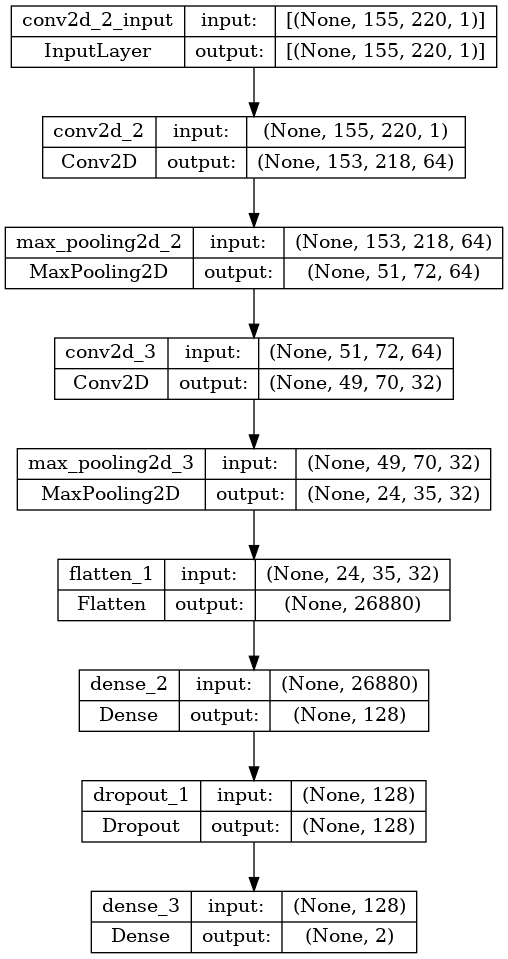

In [15]:
model.summary()
print("The layers in the CNN Model are \n")
tf.keras.utils.plot_model(model, to_file="base_model.png", show_shapes=True)

In [16]:
model.save('cnn.h5')

**Plotting graphs for Accuracy and Loss**

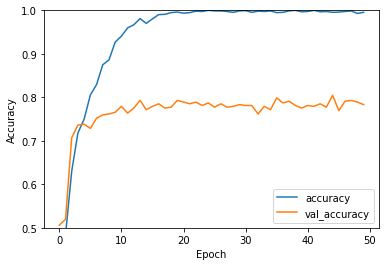

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.savefig("accuracy_plot.png")

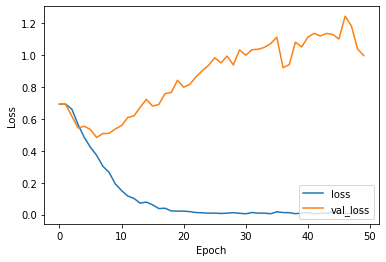

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.savefig("loss_plot.png")

**Evaluating the validation accuracy and Validation loss**

In [19]:
validation_loss, validation_acc = model.evaluate(data_validation)

8/8 [==============================] - 1s 153ms/step - loss: 0.9981 - accuracy: 0.7832


In [20]:
print("The validation loss is = ",validation_loss)

The validation loss is =  0.9981099367141724


In [21]:
print("The validation accuracy is = ",validation_acc)

The validation accuracy is =  0.783203125


**Evaluating the Test accuracy and Test loss**

In [22]:
test_loss, test_acc = model.evaluate(data_testing)

8/8 [==============================] - 1s 157ms/step - loss: 0.8415 - accuracy: 0.8203


In [23]:
print("The testing loss is = ",test_loss)

The testing loss is =  0.841469943523407


In [24]:
print("The testing accuracy is = ",test_acc)

The testing accuracy is =  0.8203125


In [26]:
print('\n Test Signature Details : \n')
type=input('Enter forg for forged and org for genuine signature : ')
s = input('Enter signer number(1 to 55) : ')
s2=input('Enter signature number for signer number '+s+'(1 to 24) : ') 

if(type=='forg'):
  st='forgeries'
elif(type=='org'):
  st='original'

inp = cv2.imread('signatures/full_'+type+'/'+st+'_'+s+'_'+s2+'.png')

inp = sig_process(inp)
                   
inp = np.expand_dims(inp,axis=0)

inp_pred = model.predict([inp])
inp_pred = np.round(inp_pred)

print(inp_pred)

if (inp_pred[0][0] == 0):
  print('The signature is genuine \n')
elif(inp_pred[0][0]>=1):
  print('The signature is forged \n')



 Test Signature Details : 



Enter forg for forged and org for genuine signature :  org
Enter signer number(1 to 55) :  2
Enter signature number for signer number 2(1 to 24) :  5


1/1 [==============================] - 0s 11ms/step
[[0. 1.]]
The signature is genuine 

